# Resnet 101 dropout 0,4, no weights

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

2024-06-18 21:56:21.234708: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 21:56:21.333094: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 21:56:21.713469: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 21:56:22.786854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Lokacija dataset-a

In [2]:
dataset_path = "../../data_set"

In [3]:
classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]


Inicijalizacija lista za cuvanje podataka


In [4]:
data = []
labels = []

Ucitavanje slika kroz klase


In [5]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "Training", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Učitavanje slike u crno-belom formatu
        img = cv2.resize(img, (224, 224))  # Da sve slike budu 224x224px
        img = np.stack((img,)*3, axis=-1)  # tri kanala od grayscale slike (resnet-u treba 3 kanala)
        data.append(img)
        labels.append(classes.index(class_name))

Konvertovanje listi u numpy


In [6]:
data = np.array(data) / 255.0  # Normalizacija vrednosti piksela
labels = np.array(labels)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)


ImageDataGenerator za data augmentation


In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

ResNet-50 model

In [9]:
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-10:]:
    layer.trainable = True

Dodavanje prilagođenih slojeva

In [10]:
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
outputs = Dense(len(classes), activation='softmax')(x)


In [11]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Cuvanje tezina

In [12]:
checkpoint_path = "model.weights.h5" 
checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')

Treniranje modela

In [13]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=4), epochs=20, validation_data=(X_val, y_val), callbacks=[checkpoint])



Epoch 1/20


/home/teki/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


574/574 ━━━━━━━━━━━━━━━━━━━━ 1190s 2s/step - accuracy: 0.3441 - loss: 3.8389 - val_accuracy: 0.3118 - val_loss: 1.4866
Epoch 2/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 1161s 2s/step - accuracy: 0.3742 - loss: 1.3734 - val_accuracy: 0.4965 - val_loss: 1.2836
Epoch 3/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 1141s 2s/step - accuracy: 0.4304 - loss: 1.2645 - val_accuracy: 0.3693 - val_loss: 1.3532
Epoch 4/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 1148s 2s/step - accuracy: 0.4467 - loss: 1.2214 - val_accuracy: 0.4164 - val_loss: 1.2310
Epoch 5/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 1151s 2s/step - accuracy: 0.4715 - loss: 1.1902 - val_accuracy: 0.2857 - val_loss: 11.9484
Epoch 6/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 1148s 2s/step - accuracy: 0.4932 - loss: 1.1508 - val_accuracy: 0.3780 - val_loss: 1.3641
Epoch 7/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 1160s 2s/step - accuracy: 0.5252 - loss: 1.1131 - val_accuracy: 0.5732 - val_loss: 1.1783
Epoch 8/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 1149s 2s/step - accuracy: 0.5806 - loss: 1.0517 - val_accura

Evaluacija modela na test skupu


In [13]:
test_data = []
test_labels = []

In [14]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "Testing", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        img = np.stack((img,)*3, axis=-1)
        test_data.append(img)
        test_labels.append(classes.index(class_name))

In [15]:
test_data = np.array(test_data) / 255.0

test_labels = np.array(test_labels)

In [16]:
model.load_weights(checkpoint_path)

/home/teki/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 846 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Classification report

In [17]:
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
report = classification_report(test_labels, predicted_classes, target_names=classes)
print("Classification report:")
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step
Classification report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.14      0.25       100
meningioma_tumor       0.42      0.88      0.57       115
        no_tumor       0.65      0.47      0.54       105
 pituitary_tumor       0.74      0.65      0.69        74

        accuracy                           0.54       394
       macro avg       0.70      0.53      0.51       394
    weighted avg       0.69      0.54      0.50       394



Preciznost je vrlo visoka za glioma tumore, ali niska za meningioma tumore. Ostale klase imaju srednju preciznost.

Odziv je vrlo visok za meningioma tumore, dok je veoma nizak za glioma tumore. Ostale klase imaju srednji odziv.

F1-score vrednosti pokazuju da model ima umerene performanse za sve klase, sa nešto boljim performansama za meningioma tumore i pituitary tumore.

Čuvanje rezultata


In [18]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)

2024-06-18 21:58:45.279800: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1382449152 exceeds 10% of free system memory.


In [19]:
results = {
    "Model": ["ResNet101 - no dropout"],
    "Train Loss": [train_loss],
    "Train Accuracy": [train_accuracy],
    "Validation Loss": [val_loss],
    "Validation Accuracy": [val_accuracy],
    "Test Loss": [test_loss],
    "Test Accuracy": [test_accuracy]
}

In [20]:
results_df = pd.DataFrame(results)
results_df.to_csv("model_results_resnet101_no_dropout.csv", index=False)
print(results_df)

                    Model  Train Loss  Train Accuracy  Validation Loss  \
0  ResNet101 - no dropout    0.578656        0.807927         0.592354   

   Validation Accuracy  Test Loss  Test Accuracy  
0             0.801394   1.836261       0.538071  


In [21]:
history = {
    'accuracy': [
        0.3441, 0.3742, 0.4304, 0.4467, 0.4715, 0.4932, 0.5252, 0.5806, 
        0.5711, 0.5940, 0.6073, 0.6286, 0.6491, 0.6740, 0.6917, 0.7131, 
        0.7335, 0.7490, 0.7728, 0.7696
    ],
    'loss': [
        3.8389, 1.3734, 1.2645, 1.2214, 1.1902, 1.1508, 1.1131, 1.0517, 
        1.0469, 0.9822, 0.9568, 0.9125, 0.8611, 0.8130, 0.8154, 0.7652, 
        0.7367, 0.6759, 0.6330, 0.6614
    ],
    'val_accuracy': [
        0.3118, 0.4965, 0.3693, 0.4164, 0.2857, 0.3780, 0.5732, 0.4477, 
        0.1707, 0.2962, 0.4791, 0.6882, 0.3223, 0.7787, 0.5732, 0.1829, 
        0.6446, 0.8014, 0.2247, 0.2770
    ],
    'val_loss': [
        1.4866, 1.2836, 1.3532, 1.2310, 11.9484, 1.3641, 1.1783, 1.1757, 
        3.4018, 1.5517, 1.3415, 0.7958, 2.4879, 0.6207, 1.1994, 2.7950, 
        0.8824, 0.5924, 2.1109, 1.8568
    ]
}

Graficki prikaz rezultata

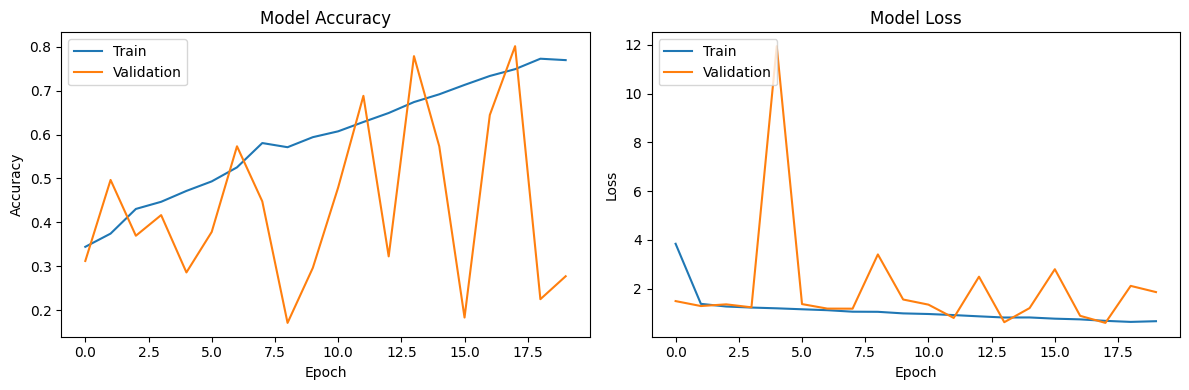

: 

In [22]:
# train history
plt.figure(figsize=(12, 4))

# Plot training, validation
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training, validation
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()